# New York City Taxi Trip Duration
Соревнование на Kaggle - https://www.kaggle.com/c/nyc-taxi-trip-duration/overview. Нужно предсказать продолжительность поездки такси по следующим признакам:

- id - идентификатор поездки
- vendor_id - код провайдера, от которого пришла информация о поездке
- pickup_datetime - время старта поездки
- dropoff_datetime - время окончания поездки
- passenger_count - число пассажиров (вводится водителем)
- pickup_longitude - долгота точки посадки
- pickup_latitude - широта точки посадки
- dropoff_longitude - долгота точки высадки
- dropoff_latitude - долгота точки высадки
- store_and_fwd_flag - равно Y, если информация о поездке какое-то время хранилась в памяти таксометра из-за отсутствия связи; иначе принимает значение N
- trip_duration - продолжительность поездки в секундах


## Разведовочный анализ

### Подготовка данных
Подключаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

Загружаем и просматриваем тренировочные и тестовые данные

In [2]:
data_train = pd.read_csv('../nyc-taxi-trip-duration/train.csv')
data_test = pd.read_csv('../nyc-taxi-trip-duration/test.csv')

In [3]:
data_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
data_train.shape

(1458644, 11)

In [5]:
data_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [6]:
data_test.shape

(625134, 9)

Колонка dropoff_datetime отсутствует в тестовой выборке, значит в будущем нам следует ее удалить.

Проверям, есть ли пропущенные значения в данных:

In [7]:
data_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Проверяеим типы переменных: 

In [8]:
data_train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Столбцы с датами были отнесены к типу object. Для удобства будет лучше преобразовать их в тип datetime:

In [9]:
data_train['pickup_datetime'] = pd.to_datetime(data_train['pickup_datetime'])
data_train['dropoff_datetime'] = pd.to_datetime(data_train['dropoff_datetime'])

### Целевая переменная

Посмотрим теперь на целевую переменную, а именно на колонку trip_duration, построим ее распределение.

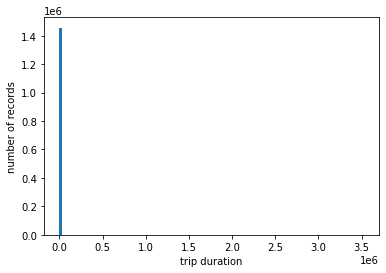

In [10]:
plt.hist(data_train['trip_duration'].values, bins = 100)
plt.xlabel("trip duration")
plt.ylabel("number of records")
plt.show()

Получилось не очень информативно, поробуем логарифмировать целевую пременную и вновь построить распределение. Используем для этого np.log1p логарифмирующий следующим образом: log(1 + x)

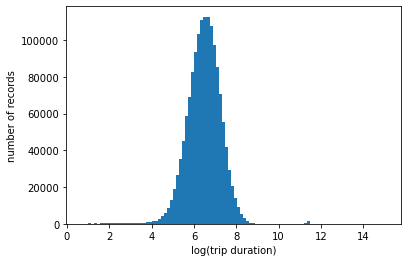

In [11]:
data_train['log_trip_duration'] = np.log1p(data_train['trip_duration'].values)
plt.hist(data_train['log_trip_duration'].values, bins = 100)
plt.xlabel("log(trip duration)")
plt.ylabel("number of records")
plt.show()

В основном, длительность всех поездок варьируется в следующих пределах:

In [12]:
print("from {} to {} in seconds".format(np.exp(4.5), np.exp(9)))
print("from {} to {} in minutes".format(np.exp(4.5) // 60, np.exp(9) // 60))

from 90.01713130052181 to 8103.083927575384 in seconds
from 1.0 to 135.0 in minutes


На верхнем графике между значениями 10 и 12 на оси абсцисс видно, что есть отдельный блок заказов с нетипично большой длительностью нужно присмотреться к нему повниметельнее.

In [13]:
lower_border = np.exp(10) // 3600
print("10 on log(trip_duration) is",(np.exp(10) -1) // 3600, "hours")

10 on log(trip_duration) is 6.0 hours


In [14]:
print("11 on log(trip_duration) is",(np.exp(11)-1) // 3600, "hours")

11 on log(trip_duration) is 16.0 hours


In [15]:
data_train['trip_duration'].max() // 3600

979

Поездка длительностью 979 часов точно является выбросом. Посмотрим сколько всего таких выбросов присутствует в нашей выборке.

In [16]:
data_train['trip_duration_in_hours'] = data_train['trip_duration'] // 3600
big_duration = data_train[data_train['trip_duration_in_hours'] >= 6]['trip_duration_in_hours']
print("number of trips that are longer than 6 hours = ", big_duration.count())

number of trips that are longer than 6 hours =  2061


In [17]:
big_duration.unique()

array([ 23,  22,  10,  11,  13,  12,  17,  14,   6,  18,  21,  16,   7,
         8,  20,  15, 538,  19,   9, 569, 618, 979], dtype=int64)

Поездки длительностью 538, 569, 618 часов тоже записываем как выбросы

### Работа с pickup_datetime переменной

Добавим следующие признаки в датасет

- pickup_date - дата без времени
- pickup_day - число месяца
- pickup_day_of_the_week - день недели
- pickup_month - месяц
- pickup_hour - час начала поездки

In [18]:
data_train['pickup_date'] = data_train['pickup_datetime'].dt.date
data_train['pickup_day'] = data_train['pickup_datetime'].apply(lambda x: x.day)
data_train['pickup_day_of_the_week'] = data_train['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
data_train['pickup_month'] = data_train['pickup_datetime'].apply(lambda x: x.month)
data_train['pickup_hour'] = data_train['pickup_datetime'].apply(lambda x: x.hour)

Посмотрим на количество поездок в различные дни месяца

<AxesSubplot:xlabel='pickup_day', ylabel='count'>

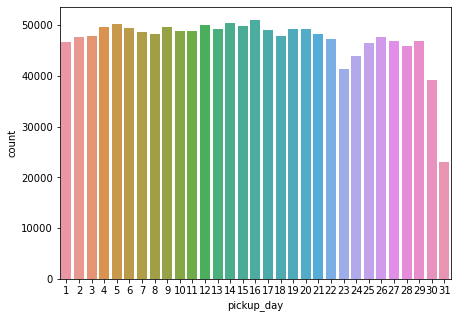

In [19]:
plt.figure(figsize = (7,5))
sns.countplot(x = 'pickup_day', data = data_train)

Рассмотрим теперь количество поедок на всем временном интервале представленном в датасете

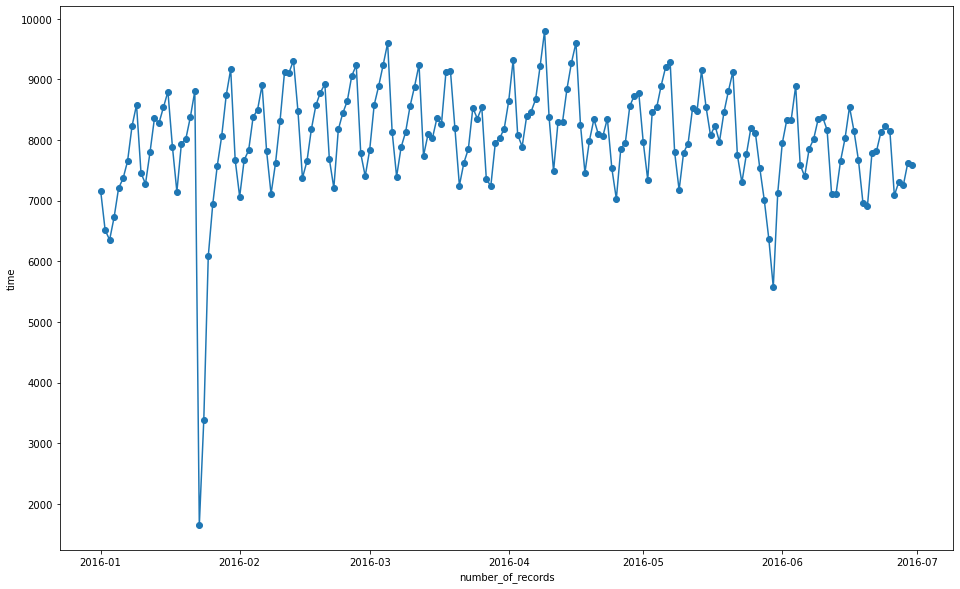

In [20]:
plt.figure(figsize = (16,10))
plt.plot(data_train.groupby('pickup_date').count()[['id']], 'o-')
plt.xlabel('number_of_records')
plt.ylabel('time')
plt.show()

На графике видно что есть период с слишком маленьким количеством заказов. Вычислим время, когда это случилось и посмотрим, что могло повлиять на такой итог

In [21]:
df = data_train.groupby('pickup_date').count()[['id']].reset_index()

In [22]:
df.sort_values(by = ['id'], ascending = True)[:10]

,pickup_date,id
22,2016-01-23,1648
23,2016-01-24,3383
150,2016-05-30,5570
24,2016-01-25,6084
2,2016-01-03,6353
149,2016-05-29,6372
1,2016-01-02,6512
3,2016-01-04,6725
171,2016-06-20,6910
25,2016-01-26,6941


Самое низкое количество заказов пришлось на 23 и 24 января 2016 года. Как раз именно эти дни выделяются на графике сверху. В период с 23 по 24 по данным Википедии был введен запрет на передвижение по городу из-за мощнейшей снежной бури - https://en.wikipedia.org/wiki/January_2016_United_States_blizzard

Количество поездок по дням недели

<AxesSubplot:xlabel='pickup_day_of_the_week', ylabel='count'>

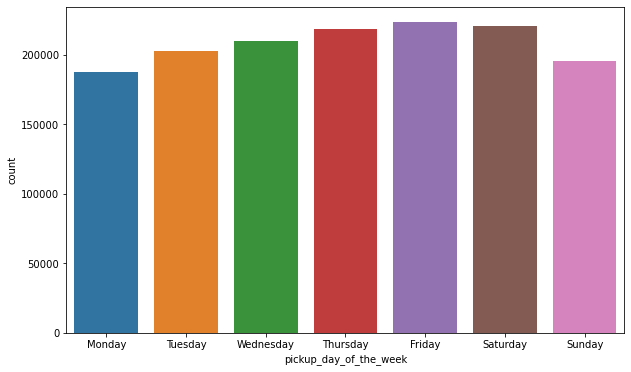

In [23]:
plt.figure(figsize = (10,6))
sns.countplot(x = 'pickup_day_of_the_week', data = data_train, order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Средняя длина поездки по дням недели

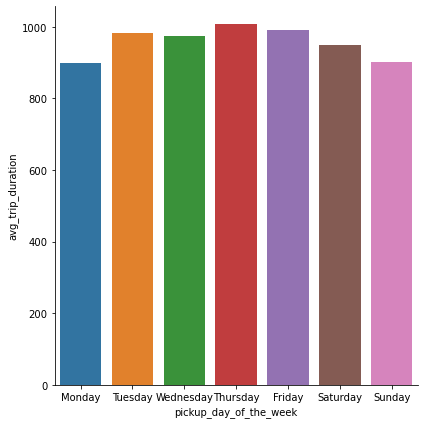

In [24]:
avg_trip_duration = data_train.groupby(['pickup_day_of_the_week'])['trip_duration'].mean().reset_index()
avg_trip_duration.rename(columns = {'trip_duration' : 'avg_trip_duration'}, inplace = True)
sns.catplot(x = 'pickup_day_of_the_week', y = 'avg_trip_duration', data = avg_trip_duration, height = 6, kind = 'bar', order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

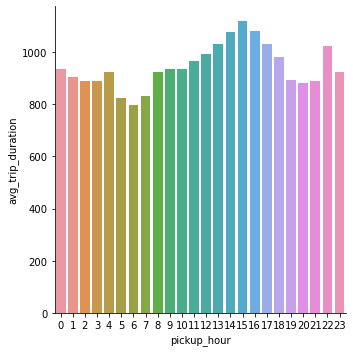

In [25]:
avg_trip_duration_hours = data_train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index()
avg_trip_duration_hours.rename(columns = {'trip_duration': 'avg_trip_duration'}, inplace = True)
sns.catplot(x = 'pickup_hour', y = 'avg_trip_duration', data = avg_trip_duration_hours, kind = 'bar')

## Обучение на необработанных данных и константные предположения

In [26]:
data_train = pd.read_csv('../nyc-taxi-trip-duration/train.csv')

Попробуем обучиться на необработанных данных без выделения дополнительных признаков. Предсказывать будем логарифмированную длительность поездки. Чтобы получить первоначальную длительность необходимо будет сделать обратное преобразование.

In [27]:
y = data_train['trip_duration'].apply(lambda x: np.log1p(x))
y1 = data_train['trip_duration']
data_train.drop(columns = ['trip_duration', 'dropoff_datetime', 'id', 'pickup_datetime'], inplace = True)

In [28]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [29]:
data_train.dtypes

vendor_id               int64
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object

Выделим численные и категориальные признаки

In [30]:
numeric_features = list(data_train.select_dtypes(include = ['int64', 'float64']).columns)
categorical_features = list(data_train.select_dtypes(include = ['object']).columns)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(data_train, y, train_size = 0.7, random_state = 10)

In [32]:
column_transformer = make_column_transformer((OneHotEncoder(), categorical_features), (StandardScaler(), numeric_features))
column_transformer.fit_transform(x_train)
column_transformer.fit_transform(x_test)

array([[ 1.        ,  0.        ,  0.93018561, ..., -0.60313336,
        -0.41221431, -0.68758014],
       [ 1.        ,  0.        , -1.07505426, ...,  0.84829264,
        -0.68350565, -0.11660056],
       [ 1.        ,  0.        ,  0.93018561, ..., -0.9765934 ,
        -0.8381162 , -0.99443383],
       ...,
       [ 1.        ,  0.        , -1.07505426, ..., -0.51914379,
        -0.39945766, -0.17155149],
       [ 1.        ,  0.        ,  0.93018561, ...,  0.79665284,
        -0.40524067, -0.04815103],
       [ 1.        ,  0.        , -1.07505426, ..., -1.45536988,
         0.02661432, -0.0511271 ]])

In [33]:
for model in [LinearRegression(), Lasso(), Ridge()]:
    pipe = make_pipeline(column_transformer, model)
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    print(model)
    print('mse = %.4f' %mean_squared_error(y_test, y_pred))
    print('rmse = %.4f' %mean_squared_error(y_test, y_pred, squared = False))
    print('mae = %.4f' %mean_absolute_error(y_test, y_pred))

LinearRegression()
mse = 0.6051
rmse = 0.7779
mae = 0.5892
Lasso()
mse = 0.6309
rmse = 0.7943
mae = 0.6049
Ridge()
mse = 0.6051
rmse = 0.7779
mae = 0.5892


Ниже предсказанием является среднее значение целевой переменной

In [34]:
mean_absolute_error(y, np.median(y) * np.ones(y.shape))

0.6049636530936547

In [35]:
mean_squared_error(y, np.median(y) * np.ones(y.shape))

0.6341205987731969

In [36]:
mean_squared_error(y, np.median(y) * np.ones(y.shape), squared = False)

0.7963168959485897

Примем во внимание факт, что MSE зависит от выбросов, которых в выборке большое количество. Поэтому если обратить внимание только на MAE модель с константным предположением будет ошибаться в среднем на 9.5 минут

In [37]:
mean_absolute_error(y1, np.median(y1) * np.ones(y1.shape))

566.742495770044

In [38]:
mean_squared_error(y1, np.median(y1) * np.ones(y1.shape))

27519173.91563466

rmse ошибка = 87.5 минутам

In [39]:
mean_squared_error(y1, np.median(y1) * np.ones(y1.shape), squared = False)

5245.872083422799

## Обучение на новых признаках
### Функции предобработки и выделения признаков

Функция возвращает датафрейм без признаков trip_duration, dropoff_datetime, id и логарифмированную целевую переменную

In [40]:
def first_preprocessing(df):
    df = df.copy()
    
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    y = df['trip_duration'].apply(lambda x: np.log1p(x))
    df.drop(columns = ['trip_duration', 'dropoff_datetime', 'id'], inplace = True)
    
    return df, y

Возвращаяет численные и вещественные признаки

In [41]:
def get_numeric_categorical_features(df):
    numeric_features = list(df.select_dtypes(include = ['int64', 'float64']).columns)
    categorical_features = list(df.select_dtypes(include = ['object']).columns)
    return numeric_features, categorical_features

Возвращает новый датафрейм с логарифмированным расстоянием на сфере

In [42]:
def distance(df):
    df = df.copy()
    lat1 = df['pickup_latitude'].values
    lng1 = df['pickup_longitude'].values
    lat2 = df['dropoff_latitude'].values
    lng2 = df['dropoff_longitude'].values
    
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    df['distance'] = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    df['distance'] = df['distance'].apply(lambda x: np.log1p(x)) 
    df.drop(columns = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], inplace = True)
    return df

Возвращает датафрейм с признаком - день недели

In [43]:
def day_of_week(df):
    df = df.copy()
    
    tmp = df['pickup_datetime'].dt.date
    df['pickup_day_of_the_week'] = tmp.apply(lambda x: calendar.day_name[x.weekday()])
    
    return df

Возвращает датафрейм с признаком - день месяца

In [44]:
def day_of_month(df):
    df = df.copy()
    
    df['pickup_day'] = data_train['pickup_datetime'].apply(lambda x: x.day)
    
    return df

Возвращает датафрейм с признаком - чило месяца

In [45]:
def month(df):
    df = df.copy()
    
    df['pickup_month'] = data_train['pickup_datetime'].apply(lambda x: x.month)
    
    return df

Возвращает датафрейм с признаком - время суток

In [46]:
def hour_of_day(df):
    df = df.copy()
    
    df['pickup_hour'] = data_train['pickup_datetime'].apply(lambda x: x.hour)
    
    return df

### Обучение на новых признаках с выбросами

In [47]:
data_train = pd.read_csv('../nyc-taxi-trip-duration/train.csv')

data_train,y = first_preprocessing(data_train)
data_train = distance(data_train)
data_train = day_of_week(data_train)
data_train = day_of_month(data_train)
data_train = hour_of_day(data_train)
data_train = month(data_train)

In [48]:
data_train.head()

,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,distance,pickup_day_of_the_week,pickup_day,pickup_hour,pickup_month
0,2,2016-03-14 17:24:55,1,N,0.915699,Monday,14,17,3
1,1,2016-06-12 00:43:35,1,N,1.031584,Sunday,12,0,6
2,2,2016-01-19 11:35:24,1,N,1.999464,Tuesday,19,11,1
3,2,2016-04-06 19:32:31,1,N,0.910473,Wednesday,6,19,4
4,2,2016-03-26 13:30:55,1,N,0.783257,Saturday,26,13,3


In [49]:
data_train.dtypes

vendor_id                          int64
pickup_datetime           datetime64[ns]
passenger_count                    int64
store_and_fwd_flag                object
distance                         float64
pickup_day_of_the_week            object
pickup_day                         int64
pickup_hour                        int64
pickup_month                       int64
dtype: object

In [50]:
numeric, categorical = get_numeric_categorical_features(data_train)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(data_train, y, train_size = 0.7, random_state = 10)

In [52]:
column_transformer = make_column_transformer((OneHotEncoder(), categorical), (StandardScaler(), numeric))
column_transformer.fit_transform(x_train)
column_transformer.fit_transform(x_test)

array([[ 1.        ,  0.        ,  0.        , ...,  0.86108062,
        -2.12598065, -1.49981269],
       [ 1.        ,  0.        ,  0.        , ..., -0.63215206,
         0.84283208, -0.90475907],
       [ 1.        ,  0.        ,  0.        , ..., -0.40242396,
        -1.18846084,  0.88040179],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -1.55106448,
        -0.71970094,  0.88040179],
       [ 1.        ,  0.        ,  0.        , ..., -1.09160827,
        -0.71970094,  0.28534817],
       [ 1.        ,  0.        ,  0.        , ...,  0.17189631,
         0.37407218, -0.30970545]])

In [53]:
for model in [LinearRegression(), Lasso(), Ridge()]:
    pipe = make_pipeline(column_transformer, model)
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    print(model)
    print('mse = %.4f' %mean_squared_error(y_test, y_pred))
    print('rmse = %.4f' %mean_squared_error(y_test, y_pred, squared = False))
    print('mae = %.4f' %mean_absolute_error(y_test, y_pred))

LinearRegression()
mse = 0.2689
rmse = 0.5185
mae = 0.3672
Lasso()
mse = 0.6309
rmse = 0.7943
mae = 0.6049
Ridge()
mse = 0.2689
rmse = 0.5185
mae = 0.3672


Результат на моделях линейной регрессии и модели с l2 регуляризацией значительно улучшился по сравнению с обучением на сырых данных. l1 регуляризация по прежнему имеет плохие показатели.

### Удаление выбросов

In [54]:
data_train = pd.read_csv('../nyc-taxi-trip-duration/train.csv')

In [55]:
data_train.shape

(1458644, 11)

Удаляем слишком длительные поездки

In [56]:
data_train = data_train.drop(data_train[data_train['trip_duration'] > 20000].index)

In [57]:
data_train.shape

(1456576, 11)

Удаляем записи дни, когда был режим ЧС

In [58]:
data_train['date'] = pd.to_datetime(data_train['pickup_datetime']).dt.date
data_train = data_train.drop(data_train[data_train['date'] == pd.to_datetime('2016-01-23')].index)
data_train = data_train.drop(data_train[data_train['date'] == pd.to_datetime('2016-01-24')].index)
data_train = data_train.drop(columns = ['date'])

C:\Users\serec\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [59]:
data_train.shape

(1451556, 11)

### Обучение на данных без выбросов и с новыми признаками

In [60]:
data_train,y = first_preprocessing(data_train)
data_train = distance(data_train)
data_train = day_of_week(data_train)
data_train = day_of_month(data_train)
data_train = hour_of_day(data_train)
data_train = month(data_train)

In [61]:
data_train = data_train.drop(columns = ['pickup_datetime'])

In [62]:
data_train.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance,pickup_day_of_the_week,pickup_day,pickup_hour,pickup_month
0,2,1,N,0.915699,Monday,14,17,3
1,1,1,N,1.031584,Sunday,12,0,6
2,2,1,N,1.999464,Tuesday,19,11,1
3,2,1,N,0.910473,Wednesday,6,19,4
4,2,1,N,0.783257,Saturday,26,13,3


In [63]:
numeric, categorical = get_numeric_categorical_features(data_train)
x_train, x_test, y_train, y_test = train_test_split(data_train, y, train_size = 0.7, random_state = 10)
column_transformer = make_column_transformer((OneHotEncoder(), categorical), (StandardScaler(), numeric))
column_transformer.fit_transform(x_train)
column_transformer.fit_transform(x_test)

array([[ 1.        ,  0.        ,  0.        , ...,  1.20775633,
        -0.09758844,  1.47267935],
       [ 1.        ,  0.        ,  0.        , ...,  1.32265327,
        -0.8798477 , -1.50494682],
       [ 1.        ,  0.        ,  1.        , ..., -1.43487349,
        -1.34920325,  1.47267935],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.40080095,
         0.99757451,  1.47267935],
       [ 1.        ,  0.        ,  0.        , ...,  1.43755022,
         1.46693006,  0.87715412],
       [ 1.        ,  0.        ,  0.        , ..., -0.86038875,
         0.84112266,  0.87715412]])

In [64]:
for model in [LinearRegression(), Lasso(), Ridge()]:
    pipe = make_pipeline(column_transformer, model)
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    print(model)
    print('mse = %.4f' %mean_squared_error(y_test, y_pred))
    print('rmse = %.4f' %mean_squared_error(y_test, y_pred, squared = False))
    print('mae = %.4f' %mean_absolute_error(y_test, y_pred))

LinearRegression()
mse = 0.2365
rmse = 0.4863
mae = 0.3610
Lasso()
mse = 0.5989
rmse = 0.7739
mae = 0.5993
Ridge()
mse = 0.2365
rmse = 0.4863
mae = 0.3610


Получилось еще уменьшить ошибку в модели линейной регрессии и модели с l2 регуляризацией. Ожидаемо l1 регуляризация показывает плохой результат. Заметим, что LinearRegression и Ridge ведут себя одинаково

### Подбор гиперпараметров

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [66]:
ct = ColumnTransformer([('ohe', OneHotEncoder(), categorical), ('ss', StandardScaler(), numeric)], remainder = 'passthrough')
ct.fit(x_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(),
                                 ['store_and_fwd_flag',
                                  'pickup_day_of_the_week']),
                                ('ss', StandardScaler(),
                                 ['vendor_id', 'passenger_count', 'distance',
                                  'pickup_day', 'pickup_hour',
                                  'pickup_month'])])

In [67]:
ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(),
                                 ['store_and_fwd_flag',
                                  'pickup_day_of_the_week']),
                                ('ss', StandardScaler(),
                                 ['vendor_id', 'passenger_count', 'distance',
                                  'pickup_day', 'pickup_hour',
                                  'pickup_month'])])

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(),
                                 ['store_and_fwd_flag',
                                  'pickup_day_of_the_week']),
                                ('ss', StandardScaler(),
                                 ['vendor_id', 'passenger_count', 'distance',
                                  'pickup_day', 'pickup_hour',
                                  'pickup_month'])])

In [68]:
pipe = Pipeline([('ct', ct), ('model', Ridge())])

In [69]:
alphas = np.logspace(-2,4, 20)
params = {
    'model__alpha' : alphas
}

In [70]:
gs = GridSearchCV(pipe, params, cv = 5, scoring = 'neg_mean_squared_error')
gs.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['store_and_fwd_flag',
                                                                          'pickup_day_of_the_week']),
                                                                        ('ss',
                                                                         StandardScaler(),
                                                                         ['vendor_id',
                                                                          'passenger_count',
                                                                          'distance',
                                                

Best alpha 61.5848
Best score 0.2384


Text(0, 0.5, 'CV score')

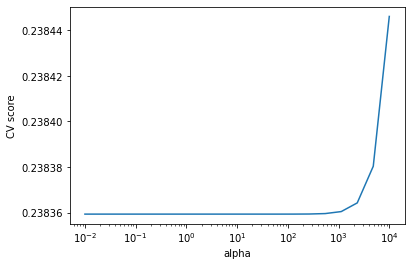

In [71]:
best_alpha = gs.best_params_['model__alpha']
best_score = gs.best_score_
print("Best alpha %.4f" %best_alpha)
print("Best score %.4f" % -best_score)

plt.plot(alphas, -gs.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [72]:
y_pred = gs.predict(x_test)

In [73]:
mean_squared_error(y_test, y_pred)


0.23647238404094037

In [74]:
mean_absolute_error(y_test, y_pred)

0.36099602033719946

In [75]:
mean_squared_error(y_test, y_pred, squared = False)

0.4862842625881907

### Random Forest

In [76]:
from sklearn.ensemble import RandomForestRegressor

In [77]:
ct = ColumnTransformer([('ohe', OneHotEncoder(), categorical), ('ss', StandardScaler(), numeric)])
pipe = Pipeline([('ct', ct),('model', RandomForestRegressor(n_estimators = 10))]) 

In [78]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['store_and_fwd_flag',
                                                   'pickup_day_of_the_week']),
                                                 ('ss', StandardScaler(),
                                                  ['vendor_id',
                                                   'passenger_count',
                                                   'distance', 'pickup_day',
                                                   'pickup_hour',
                                                   'pickup_month'])])),
                ('model', RandomForestRegressor(n_estimators=10))])

In [79]:
y_pred = pipe.predict(x_test)

In [80]:
mean_squared_error(y_test, y_pred)

0.21237391466430947

In [81]:
mean_squared_error(y_test, y_pred, squared = False)

0.46084044382444284

In [82]:
mean_absolute_error(y_test, y_pred)

0.3365528135290374

В среднем ошибка равна 4 минутам. то есть удалось уменьшить ошибку на 5.5 минут

In [83]:
time_test = np.exp(y_test)-1
time_pred = np.exp(y_pred)-1

In [84]:
mean_absolute_error(time_test, time_pred)

242.209875517631

In [85]:
mean_squared_error(time_test, time_pred, squared = False)

375.4501301960089

### Gradient Boosting

In [86]:
import xgboost as xgb

In [87]:
ct = ColumnTransformer([('ohe', OneHotEncoder(), categorical), ('ss', StandardScaler(), numeric)], remainder = 'passthrough')
ct.fit_transform(x_train)

array([[ 1.        ,  0.        ,  0.        , ..., -0.51352404,
         1.31221379,  1.47631182],
       [ 1.        ,  0.        ,  0.        , ...,  1.55421498,
         0.21807562, -0.90943349],
       [ 1.        ,  0.        ,  0.        , ..., -0.74327282,
        -1.50128436, -1.50586982],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -1.66226794,
         0.06177017, -0.31299716],
       [ 1.        ,  0.        ,  0.        , ..., -1.08789599,
         0.68699198, -0.90943349],
       [ 1.        ,  0.        ,  1.        , ..., -0.85814721,
         0.06177017, -1.50586982]])

In [88]:
model = xgb.XGBRegressor(n_estimators = 120)
pipe = Pipeline([('ct', ct),('model', model)])
pipe.fit(x_train, y_train, model__eval_metric = 'mae')

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  ['store_and_fwd_flag',
                                                   'pickup_day_of_the_week']),
                                                 ('ss', StandardScaler(),
                                                  ['vendor_id',
                                                   'passenger_count',
                                                   'distance', 'pickup_day',
                                                   'pickup_hour',
                                                   'pickup_month'])])),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_byno...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interac

In [89]:
y_pred = pipe.predict(x_test)

In [90]:
mean_squared_error(y_test, y_pred)

0.17701194354663383

In [91]:
mean_squared_error(y_test, y_pred, squared = False)

0.4207278735080834

In [92]:
mean_absolute_error(y_test, y_pred)

0.30531295783704243

###  Обратные преобразования

In [94]:
time_test = np.exp(y_test)-1
time_pred = np.exp(y_pred)-1

Удалось достичь ошибки в 3.7 минуты

In [97]:
mean_absolute_error(time_test, time_pred)

220.97487099813773

Ошибка rmse = 5.9 минут

In [98]:
mean_squared_error(time_test, time_pred, squared = False)

352.0192849817219

## Выводы

Наилучший результат был достигнут с помощью метода градиентного бустинга. Удалось уменьшить ошибку в среднем до 3.6 минут на метрике MAE и до 5.9 минут на метрике RMSE. При этом константные предсказания до обработки данных и выделения признаков были следующими: MAE = 9.5 минут, а RMSE = 87.5 минут (из-за большого количества выбросов).